## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [51]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
# Load image caliberation matrix
cameraCalibration = pickle.load( open('./pickle_store/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [53]:
# undistort the image

def dist_correct(img, mtx, dist):
    return  cv2.undistort(img, mtx, dist, None, mtx)

In [91]:
def apply_hls(img, thresh_sChannel = (170, 255)):
    # get the s-channel in HLS and apply threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_sChannel[0]) & (s_channel <= thresh_sChannel[1])] = 1
    
    return s_binary

# Sobel x

def apply_sobelThresh(img, orient = 'x', sobel_kernel=3, thresh_sobel = (0, 255)):
    # apply sobel and threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel) 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    xbinary = np.zeros_like(scaled_sobel)
    xbinary[(scaled_sobel >= thresh_sobel[0]) & (scaled_sobel <= thresh_sobel[1])] = 1
    
    return xbinary

def binary_thresholds(x_binary, s_binary):
    # combine the thresholds
    combined_binary = np.zeros_like(x_binary)
    combined_binary[(s_binary == 1) | (x_binary == 1)] = 1
    
    return combined_binary

def combine_gradients(img):
    s_binary = apply_hls(img, thresh_sChannel = (170, 255))
    
    sobel_x  = apply_sobelThresh(img, orient = 'x', sobel_kernel=3, thresh_sobel = (15, 100)) #10, 160
    sobel_xThresh = binary_thresholds(sobel_x, s_binary)
    
    #sobel_y  = apply_sobelThresh(img, orient = 'y', sobel_kernel=3, thresh_sobel = (10, 160))
    #sobel_yThresh = binary_thresholds(sobel_y, s_binary)
    return sobel_xThresh
    #return binary_thresholds(sobel_xThresh, sobel_yThresh)


In [92]:
def perspective_transform(img):
    imshape = img.shape
    # define source and destination for perspective transform
    vertices = np.array([[(.55*imshape[1], 0.63*imshape[0]), (imshape[1], 0.90*imshape[0]),
                       (150,0.90*imshape[0]),(.45*imshape[1], 0.63*imshape[0])]], dtype=np.float32)
    #print(vertices)
    src= np.float32(vertices)
    dst = np.float32([[0.75*img.shape[1],0],[0.75*img.shape[1],img.shape[0]],
                      [0.25*img.shape[1],img.shape[0]],[0.25*img.shape[1],0]])
    
    src = np.float32([(532, 496),
                       (756, 496),
                       (288, 664),
                       (1016, 664)])
    dst = np.float32([(src[2][0], src[2][1] - 200),
                       (src[3][0], src[3][1] - 200),
                       (src[2][0], src[2][1]),
                       (src[3][0], src[3][1])])
    
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (imshape[1], imshape[0]) 
    warped_img = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped_img, Minv, M

In [93]:
#region of interest
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img, dtype=np.uint8)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [94]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(binary_warped, nwindows=9, margin=100, minpix=50):
    # use histogram to find the peaks in left and right half of the image
    binary_warped = binary_warped/255
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    #plt.plot(histogram)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
   
    #print(leftx_base, rightx_base, midpoint)
    # calculate window height based on number of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    #print(leftx_current, rightx_current)
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw the window
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        #print(win_y_low, win_y_high)
        #print(win_xright_low, win_xright_high)
        #print(nonzerox)
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # slide the window based on minpix value for curved lanes
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        print("error in implementation")
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each in real world terms
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)


def visualizeLanes(image):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #ax.imshow(out_img)
    #ax.plot(left_fitx, ploty, color='yellow')
    #x.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return ( left_fit, right_fit, left_fit_m, right_fit_m )
    

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


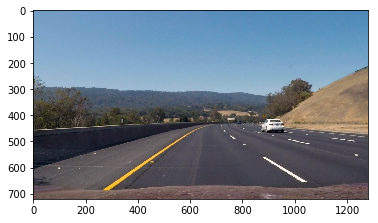

In [95]:
import os
test_image = os.listdir("test_images/")[3]
image = cv2.imread("test_images/"+ test_image)

def show_image(image):
    b,g,r = cv2.split(image)
    img = cv2.merge([r,g,b])
    print('This image is:', type(image), 'with dimensions:', image.shape)

    plt.imshow(img)

show_image(image)

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


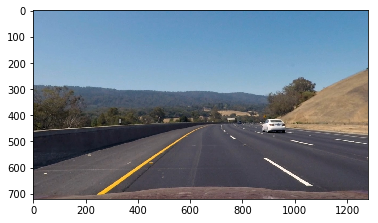

In [96]:
# data pipeline

img_org = dist_correct(image, mtx, dist)
show_image(img_org)

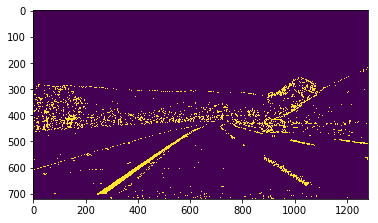

In [97]:
binary_threshold = combine_gradients(img_org)
plt.imshow(binary_threshold)

(720, 1280)


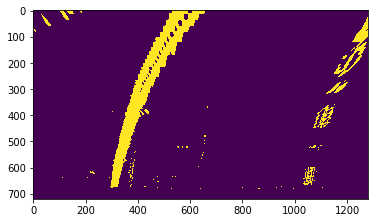

In [98]:
warped_img, Minv, M = perspective_transform(binary_threshold)
plt.imshow(warped_img)
print(warped_img.shape)

In [99]:
pickle.dump( { 'M': M, 'Minv': Minv }, open('./pickle_store/perspective_transform.p', 'wb'))

354 1051 640


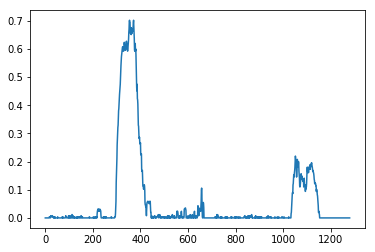

In [100]:
warped_img = warped_img/255
histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)

plt.plot(histogram)

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(leftx_base, rightx_base, midpoint)

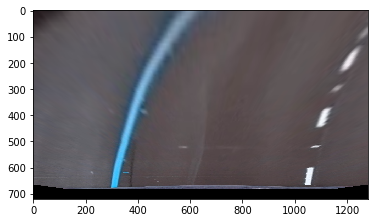

In [101]:
warped_orig, Minv_orig, M = perspective_transform(img_org)
plt.imshow(warped_orig)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


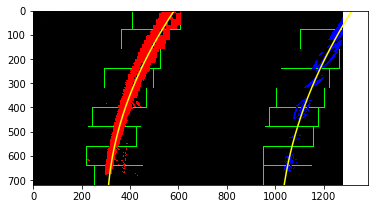

In [102]:
left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(warped_img)

In [103]:
def calculateCurvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
yRange = 719
leftCurvature = calculateCurvature(yRange, left_fit_m) 
rightCurvature = calculateCurvature(yRange, right_fit_m) 

print(' Left : {:} m, Right : {:} m'.format( leftCurvature, rightCurvature))

 Left : 412.23663219407126 m, Right : 496.2281245901693 m


In [104]:
# Lane class to track detected lanes 
class Lane():
    def __init__(self):
        self.fit = None
        self.fit_m = None
        self.radiusCurvature = None
        self.bias = None
        self.lineWidth = None

def drawLine(img, pts, left_fit, right_fit):
    
    #Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    
    Y = img.shape[0]
    ploty = np.linspace(0, Y - 1, Y)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def calculate_values(img, left_fit, right_fit, left_fit_m, right_fit_m):
    laneWidth = 0.0
    Y = img.shape[0]
    ploty = np.linspace(0, Y - 1, Y)
    #color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #output = cv2.cvtColor( output, cv2.COLOR_BGR2RGB )
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    radiusOfCurvature = (leftCurvature + rightCurvature)/2
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    
    #calculate lane width
    laneWidth = lineRight - lineLeft
    
    #print(lineLeft, lineRight)
    #print(left_fit, right_fit)
    
    #calculate vehicle offset
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    #print("inside func")
    #print(laneWidth)
    #print(type(diffFromVehicle))
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, laneWidth, radiusOfCurvature, diffFromVehicle)
    
def display_region(img, left_fit, right_fit, left_fit_m, right_fit_m, laneWidth, radiusOfCurvature, diffFromVehicle):
    
    Y = img.shape[0]
    ploty = np.linspace(0, Y - 1, Y)
    #color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #leftCurvature = calculateCurvature(yRange, left_fit_m) 
    #rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    #radiusOfCurvature = (leftCurvature + rightCurvature)/2
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale=2
    fontColor = (255, 255, 255)
    
    output = drawLine(img, pts, left_fit, right_fit)
    cv2.putText(output, 'Radius of curvature: {:.0f} m'.format(radiusOfCurvature), (50, 50), font, fontScale, fontColor, 4)
    #cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 4)
    cv2.putText(output, 'Vehicle bias is {} '.format(message), (50, 120), font, fontScale, fontColor, 4)
    
    return (output)


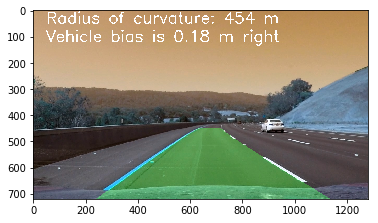

In [105]:
left_fit, right_fit, left_fit_m, right_fit_m, laneWidth, radiusOfCurvature, diffFromVehicle = calculate_values( image, left_fit, right_fit, left_fit_m, right_fit_m)
output = display_region(image, left_fit, right_fit, left_fit_m, right_fit_m, laneWidth, radiusOfCurvature, diffFromVehicle)
plt.imshow(output)

In [106]:
class Lane():
    def __init__(self):
        self.fit = None
        self.fit_m = None
        self.radiusCurvature = None
        self.bias = None
        self.laneWidth = None 
        

def advLane_pipeline(image):
    img_org = dist_correct(image, mtx, dist)
    binary_threshold = combine_gradients(img_org)
    warped_img, Minv, M = perspective_transform(binary_threshold)
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _  = findLines(warped_img)
        
    left_fit, right_fit, left_fit_m, right_fit_m, laneWidth, radiusOfCurvature, diffFromVehicle = calculate_values( image, left_fit, right_fit, left_fit_m, right_fit_m)
        
    #print("calline")
    #print(type(laneWidth))   
    #print(laneWidth)
    
    # use lanewidth to discard any misclassified or wrong detected lane lines.
    if laneWidth < 3.0 :
        left_fit = leftLane.fit
        right_fit = rightLane.fit
        left_fit_m = leftLane.fit_m
        right_fit_m = rightLane.fit_m
        radiusOfCurvature = leftLane.radiusCurvature
        diffFromVehicle = leftLane.bias
        laneWidth = leftLane.laneWidth
    else:
        leftLane.fit = left_fit
        rightLane.fit = right_fit
        leftLane.fit_m = left_fit_m
        rightLane.fit_m = right_fit_m
        leftLane.radiusCurvature = radiusOfCurvature
        rightLane.radiusCurvature = radiusOfCurvature
        leftLane.bias = diffFromVehicle
        rightLane.bias = diffFromVehicle
        leftLane.laneWidth = laneWidth
        rightLane.laneWidth = laneWidth
        
        
    
    final_image = display_region(image, left_fit, right_fit, left_fit_m, right_fit_m, laneWidth, radiusOfCurvature, diffFromVehicle)
    
    return final_image

In [107]:
image_array = os.listdir("test_images/")

for test_image in image_array:
    image = cv2.imread("test_images/"+ test_image)
    lane_image = advLane_pipeline(image)
    lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB )
    
    plt.imsave("output_images/"+test_image, lane_image)

#t_image = mpimg.imread("test_images_output/"+ test_image)


#result = 

#plt.imshow(output)

In [109]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [110]:
leftLane = Lane()
rightLane = Lane()

In [111]:
project_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(39,)
project_clip = clip1.fl_image(advLane_pipeline)
%time project_clip.write_videofile(project_output, audio=False)




                                                      

                                                               
                                                            


t:  12%|█▏        | 33/285 [1:23:30<00:30,  8.33it/s, now=None]

t:  12%|█▏        | 33/285 [1:25:18<00:30,  8.21it/s, now=None]


                                                      

                                                               
                                                            


t:  12%|█▏        | 33/285 [1:23:30<00:30,  8.33it/s, now=None]

t:  12%|█▏        | 33/285 [1:25:18<00:30,  8.21it/s, now=None]



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4







t:   0%|          | 2/1260 [00:00<03:09,  6.63it/s, now=None]



t:   0%|          | 3/1260 [00:00<03:02,  6.88it/s, now=None]



t:   0%|          | 4/1260 [00:00<02:56,  7.10it/s, now=None]



t:   0%|          | 5/1260 [00:00<02:50,  7.35it/s, now=None]



t:   0%|          | 6/1260 [00:00<02:50,  7.35it/s, now=None]



t:   1%|          | 7/1260 [00:00<02:46,  7.52it/s, now=None]



t:   1%|          | 8/1260 [00:01<02:47,  7.50it/s, now=None]



t:   1%|          | 9/1260 [00:01<02:42,  7.72it/s, now=None]



t:   1%|          | 10/1260 [00:01<02:36,  7.97it/s, now=None]



t:   1%|          | 11/1260 [00:01<02:40,  7.78it/s, now=None]



t:   1%|          | 12/1260 [00:01<02:39,  7.84it/s, now=None]



t:   1%|          | 13/1260 [00:01<02:41,  7.72it/s, now=None]



t:   1%|          | 14/1260 [00:01<02:38,  7.84it/s, now=None]



t:   1%|          | 15/1260 [00:01<02:34,  8.03it/s, now=None]



t:   1%|▏         | 16/1260 [00:02<02:34,  8.07it/s, now=None]



t:   1%|▏     

t:   8%|▊         | 107/1260 [00:14<02:39,  7.25it/s, now=None]



t:   9%|▊         | 108/1260 [00:14<02:38,  7.26it/s, now=None]



t:   9%|▊         | 109/1260 [00:14<02:42,  7.07it/s, now=None]



t:   9%|▊         | 110/1260 [00:14<02:38,  7.23it/s, now=None]



t:   9%|▉         | 111/1260 [00:14<02:34,  7.42it/s, now=None]



t:   9%|▉         | 112/1260 [00:14<02:45,  6.96it/s, now=None]



t:   9%|▉         | 113/1260 [00:15<02:39,  7.17it/s, now=None]



t:   9%|▉         | 114/1260 [00:15<02:41,  7.12it/s, now=None]



t:   9%|▉         | 115/1260 [00:15<02:33,  7.45it/s, now=None]



t:   9%|▉         | 116/1260 [00:15<02:40,  7.15it/s, now=None]



t:   9%|▉         | 117/1260 [00:15<02:38,  7.20it/s, now=None]



t:   9%|▉         | 118/1260 [00:15<02:35,  7.34it/s, now=None]



t:   9%|▉         | 119/1260 [00:15<02:31,  7.55it/s, now=None]



t:  10%|▉         | 120/1260 [00:16<02:35,  7.34it/s, now=None]



t:  10%|▉         | 121/1260 [00:16<02:32,  7.48it/s, now=None

t:  17%|█▋        | 210/1260 [00:28<02:15,  7.72it/s, now=None]



t:  17%|█▋        | 211/1260 [00:28<02:16,  7.69it/s, now=None]



t:  17%|█▋        | 212/1260 [00:28<02:18,  7.57it/s, now=None]



t:  17%|█▋        | 213/1260 [00:28<02:19,  7.50it/s, now=None]



t:  17%|█▋        | 214/1260 [00:28<02:19,  7.51it/s, now=None]



t:  17%|█▋        | 215/1260 [00:28<02:15,  7.70it/s, now=None]



t:  17%|█▋        | 216/1260 [00:28<02:13,  7.80it/s, now=None]



t:  17%|█▋        | 217/1260 [00:29<02:19,  7.47it/s, now=None]



t:  17%|█▋        | 218/1260 [00:29<02:23,  7.27it/s, now=None]



t:  17%|█▋        | 219/1260 [00:29<02:19,  7.48it/s, now=None]



t:  17%|█▋        | 220/1260 [00:29<02:18,  7.50it/s, now=None]



t:  18%|█▊        | 221/1260 [00:29<02:16,  7.62it/s, now=None]



t:  18%|█▊        | 222/1260 [00:29<02:14,  7.73it/s, now=None]



t:  18%|█▊        | 223/1260 [00:29<02:15,  7.63it/s, now=None]



t:  18%|█▊        | 224/1260 [00:30<02:19,  7.43it/s, now=None

t:  25%|██▍       | 313/1260 [00:41<02:04,  7.60it/s, now=None]



t:  25%|██▍       | 314/1260 [00:41<02:01,  7.77it/s, now=None]



t:  25%|██▌       | 315/1260 [00:42<02:00,  7.86it/s, now=None]



t:  25%|██▌       | 316/1260 [00:42<02:00,  7.84it/s, now=None]



t:  25%|██▌       | 317/1260 [00:42<02:00,  7.82it/s, now=None]



t:  25%|██▌       | 318/1260 [00:42<01:59,  7.88it/s, now=None]



t:  25%|██▌       | 319/1260 [00:42<02:04,  7.53it/s, now=None]



t:  25%|██▌       | 320/1260 [00:42<02:04,  7.54it/s, now=None]



t:  25%|██▌       | 321/1260 [00:42<02:02,  7.69it/s, now=None]



t:  26%|██▌       | 322/1260 [00:42<01:59,  7.84it/s, now=None]



t:  26%|██▌       | 323/1260 [00:43<01:58,  7.89it/s, now=None]



t:  26%|██▌       | 324/1260 [00:43<01:57,  7.98it/s, now=None]



t:  26%|██▌       | 325/1260 [00:43<02:00,  7.79it/s, now=None]



t:  26%|██▌       | 326/1260 [00:43<02:02,  7.61it/s, now=None]



t:  26%|██▌       | 327/1260 [00:43<02:08,  7.27it/s, now=None

t:  33%|███▎      | 416/1260 [00:55<01:59,  7.06it/s, now=None]



t:  33%|███▎      | 417/1260 [00:55<01:57,  7.18it/s, now=None]



t:  33%|███▎      | 418/1260 [00:55<01:55,  7.32it/s, now=None]



t:  33%|███▎      | 419/1260 [00:56<01:52,  7.46it/s, now=None]



t:  33%|███▎      | 420/1260 [00:56<01:52,  7.48it/s, now=None]



t:  33%|███▎      | 421/1260 [00:56<01:54,  7.34it/s, now=None]



t:  33%|███▎      | 422/1260 [00:56<01:49,  7.64it/s, now=None]



t:  34%|███▎      | 423/1260 [00:56<01:51,  7.48it/s, now=None]



t:  34%|███▎      | 424/1260 [00:56<01:56,  7.16it/s, now=None]



t:  34%|███▎      | 425/1260 [00:56<01:54,  7.28it/s, now=None]



t:  34%|███▍      | 426/1260 [00:57<01:51,  7.46it/s, now=None]



t:  34%|███▍      | 427/1260 [00:57<01:54,  7.26it/s, now=None]



t:  34%|███▍      | 428/1260 [00:57<01:55,  7.20it/s, now=None]



t:  34%|███▍      | 429/1260 [00:57<01:54,  7.28it/s, now=None]



t:  34%|███▍      | 430/1260 [00:57<01:53,  7.33it/s, now=None

t:  41%|████      | 519/1260 [01:09<01:41,  7.32it/s, now=None]



t:  41%|████▏     | 520/1260 [01:09<01:41,  7.30it/s, now=None]



t:  41%|████▏     | 521/1260 [01:09<01:38,  7.48it/s, now=None]



t:  41%|████▏     | 522/1260 [01:09<01:35,  7.73it/s, now=None]



t:  42%|████▏     | 523/1260 [01:09<01:36,  7.66it/s, now=None]



t:  42%|████▏     | 524/1260 [01:10<01:39,  7.41it/s, now=None]



t:  42%|████▏     | 525/1260 [01:10<01:36,  7.60it/s, now=None]



t:  42%|████▏     | 526/1260 [01:10<01:36,  7.62it/s, now=None]



t:  42%|████▏     | 527/1260 [01:10<01:36,  7.58it/s, now=None]



t:  42%|████▏     | 528/1260 [01:10<01:36,  7.62it/s, now=None]



t:  42%|████▏     | 529/1260 [01:10<01:39,  7.36it/s, now=None]



t:  42%|████▏     | 530/1260 [01:10<01:36,  7.58it/s, now=None]



t:  42%|████▏     | 531/1260 [01:11<01:38,  7.42it/s, now=None]



t:  42%|████▏     | 532/1260 [01:11<01:38,  7.42it/s, now=None]



t:  42%|████▏     | 533/1260 [01:11<01:33,  7.74it/s, now=None

t:  49%|████▉     | 622/1260 [01:22<01:32,  6.86it/s, now=None]



t:  49%|████▉     | 623/1260 [01:23<01:31,  6.94it/s, now=None]



t:  50%|████▉     | 624/1260 [01:23<01:27,  7.29it/s, now=None]



t:  50%|████▉     | 625/1260 [01:23<01:27,  7.28it/s, now=None]



t:  50%|████▉     | 626/1260 [01:23<01:30,  6.97it/s, now=None]



t:  50%|████▉     | 627/1260 [01:23<01:29,  7.04it/s, now=None]



t:  50%|████▉     | 628/1260 [01:23<01:26,  7.27it/s, now=None]



t:  50%|████▉     | 629/1260 [01:23<01:25,  7.41it/s, now=None]



t:  50%|█████     | 630/1260 [01:24<01:27,  7.23it/s, now=None]



t:  50%|█████     | 631/1260 [01:24<01:25,  7.38it/s, now=None]



t:  50%|█████     | 632/1260 [01:24<01:22,  7.60it/s, now=None]



t:  50%|█████     | 633/1260 [01:24<01:23,  7.54it/s, now=None]



t:  50%|█████     | 634/1260 [01:24<01:27,  7.14it/s, now=None]



t:  50%|█████     | 635/1260 [01:24<01:25,  7.32it/s, now=None]



t:  50%|█████     | 636/1260 [01:24<01:22,  7.53it/s, now=None

t:  58%|█████▊    | 725/1260 [01:36<01:09,  7.65it/s, now=None]



t:  58%|█████▊    | 726/1260 [01:37<01:11,  7.52it/s, now=None]



t:  58%|█████▊    | 727/1260 [01:37<01:10,  7.55it/s, now=None]



t:  58%|█████▊    | 728/1260 [01:37<01:08,  7.77it/s, now=None]



t:  58%|█████▊    | 729/1260 [01:37<01:08,  7.76it/s, now=None]



t:  58%|█████▊    | 730/1260 [01:37<01:09,  7.65it/s, now=None]



t:  58%|█████▊    | 731/1260 [01:37<01:10,  7.54it/s, now=None]



t:  58%|█████▊    | 732/1260 [01:37<01:08,  7.76it/s, now=None]



t:  58%|█████▊    | 733/1260 [01:37<01:09,  7.56it/s, now=None]



t:  58%|█████▊    | 734/1260 [01:38<01:08,  7.67it/s, now=None]



t:  58%|█████▊    | 735/1260 [01:38<01:07,  7.76it/s, now=None]



t:  58%|█████▊    | 736/1260 [01:38<01:07,  7.71it/s, now=None]



t:  58%|█████▊    | 737/1260 [01:38<01:07,  7.76it/s, now=None]



t:  59%|█████▊    | 738/1260 [01:38<01:06,  7.81it/s, now=None]



t:  59%|█████▊    | 739/1260 [01:38<01:08,  7.55it/s, now=None

t:  66%|██████▌   | 828/1260 [01:50<00:58,  7.33it/s, now=None]



t:  66%|██████▌   | 829/1260 [01:50<00:58,  7.40it/s, now=None]



t:  66%|██████▌   | 830/1260 [01:50<00:57,  7.48it/s, now=None]



t:  66%|██████▌   | 831/1260 [01:51<00:56,  7.62it/s, now=None]



t:  66%|██████▌   | 832/1260 [01:51<00:57,  7.51it/s, now=None]



t:  66%|██████▌   | 833/1260 [01:51<00:55,  7.63it/s, now=None]



t:  66%|██████▌   | 834/1260 [01:51<00:57,  7.45it/s, now=None]



t:  66%|██████▋   | 835/1260 [01:51<00:57,  7.43it/s, now=None]



t:  66%|██████▋   | 836/1260 [01:51<00:57,  7.34it/s, now=None]



t:  66%|██████▋   | 837/1260 [01:51<00:56,  7.49it/s, now=None]



t:  67%|██████▋   | 838/1260 [01:52<00:54,  7.73it/s, now=None]



t:  67%|██████▋   | 839/1260 [01:52<00:55,  7.65it/s, now=None]



t:  67%|██████▋   | 840/1260 [01:52<00:57,  7.35it/s, now=None]



t:  67%|██████▋   | 841/1260 [01:52<00:55,  7.53it/s, now=None]



t:  67%|██████▋   | 842/1260 [01:52<00:55,  7.47it/s, now=None

t:  74%|███████▍  | 931/1260 [02:05<00:44,  7.36it/s, now=None]



t:  74%|███████▍  | 932/1260 [02:05<00:43,  7.49it/s, now=None]



t:  74%|███████▍  | 933/1260 [02:05<00:43,  7.52it/s, now=None]



t:  74%|███████▍  | 934/1260 [02:05<00:43,  7.57it/s, now=None]



t:  74%|███████▍  | 935/1260 [02:05<00:42,  7.60it/s, now=None]



t:  74%|███████▍  | 936/1260 [02:05<00:46,  6.97it/s, now=None]



t:  74%|███████▍  | 937/1260 [02:05<00:44,  7.24it/s, now=None]



t:  74%|███████▍  | 938/1260 [02:06<00:43,  7.45it/s, now=None]



t:  75%|███████▍  | 939/1260 [02:06<00:43,  7.30it/s, now=None]



t:  75%|███████▍  | 940/1260 [02:06<00:43,  7.40it/s, now=None]



t:  75%|███████▍  | 941/1260 [02:06<00:41,  7.62it/s, now=None]



t:  75%|███████▍  | 942/1260 [02:06<00:41,  7.68it/s, now=None]



t:  75%|███████▍  | 943/1260 [02:06<00:41,  7.67it/s, now=None]



t:  75%|███████▍  | 944/1260 [02:06<00:41,  7.70it/s, now=None]



t:  75%|███████▌  | 945/1260 [02:07<00:40,  7.74it/s, now=None

t:  82%|████████▏ | 1034/1260 [02:19<00:33,  6.82it/s, now=None]



t:  82%|████████▏ | 1035/1260 [02:19<00:32,  6.99it/s, now=None]



t:  82%|████████▏ | 1036/1260 [02:19<00:31,  7.05it/s, now=None]



t:  82%|████████▏ | 1037/1260 [02:19<00:31,  7.05it/s, now=None]



t:  82%|████████▏ | 1038/1260 [02:19<00:32,  6.91it/s, now=None]



t:  82%|████████▏ | 1039/1260 [02:20<00:33,  6.52it/s, now=None]



t:  83%|████████▎ | 1040/1260 [02:20<00:33,  6.51it/s, now=None]



t:  83%|████████▎ | 1041/1260 [02:20<00:34,  6.40it/s, now=None]



t:  83%|████████▎ | 1042/1260 [02:20<00:34,  6.38it/s, now=None]



t:  83%|████████▎ | 1043/1260 [02:20<00:35,  6.16it/s, now=None]



t:  83%|████████▎ | 1044/1260 [02:20<00:33,  6.35it/s, now=None]



t:  83%|████████▎ | 1045/1260 [02:21<00:34,  6.18it/s, now=None]



t:  83%|████████▎ | 1046/1260 [02:21<00:33,  6.33it/s, now=None]



t:  83%|████████▎ | 1047/1260 [02:21<00:33,  6.42it/s, now=None]



t:  83%|████████▎ | 1048/1260 [02:21<00:32,  6.6

t:  90%|█████████ | 1136/1260 [02:34<00:16,  7.42it/s, now=None]



t:  90%|█████████ | 1137/1260 [02:34<00:16,  7.35it/s, now=None]



t:  90%|█████████ | 1138/1260 [02:34<00:16,  7.60it/s, now=None]



t:  90%|█████████ | 1139/1260 [02:34<00:16,  7.48it/s, now=None]



t:  90%|█████████ | 1140/1260 [02:34<00:16,  7.32it/s, now=None]



t:  91%|█████████ | 1141/1260 [02:34<00:16,  7.27it/s, now=None]



t:  91%|█████████ | 1142/1260 [02:35<00:15,  7.44it/s, now=None]



t:  91%|█████████ | 1143/1260 [02:35<00:15,  7.57it/s, now=None]



t:  91%|█████████ | 1144/1260 [02:35<00:15,  7.36it/s, now=None]



t:  91%|█████████ | 1145/1260 [02:35<00:15,  7.54it/s, now=None]



t:  91%|█████████ | 1146/1260 [02:35<00:15,  7.59it/s, now=None]



t:  91%|█████████ | 1147/1260 [02:35<00:15,  7.50it/s, now=None]



t:  91%|█████████ | 1148/1260 [02:35<00:15,  7.20it/s, now=None]



t:  91%|█████████ | 1149/1260 [02:36<00:14,  7.41it/s, now=None]



t:  91%|█████████▏| 1150/1260 [02:36<00:14,  7.5

t:  98%|█████████▊| 1238/1260 [02:47<00:02,  7.75it/s, now=None]



t:  98%|█████████▊| 1239/1260 [02:47<00:02,  7.59it/s, now=None]



t:  98%|█████████▊| 1240/1260 [02:48<00:02,  7.20it/s, now=None]



t:  98%|█████████▊| 1241/1260 [02:48<00:02,  7.25it/s, now=None]



t:  99%|█████████▊| 1242/1260 [02:48<00:02,  7.48it/s, now=None]



t:  99%|█████████▊| 1243/1260 [02:48<00:02,  7.56it/s, now=None]



t:  99%|█████████▊| 1244/1260 [02:48<00:02,  7.35it/s, now=None]



t:  99%|█████████▉| 1245/1260 [02:48<00:02,  7.33it/s, now=None]



t:  99%|█████████▉| 1246/1260 [02:48<00:01,  7.39it/s, now=None]



t:  99%|█████████▉| 1247/1260 [02:49<00:01,  7.35it/s, now=None]



t:  99%|█████████▉| 1248/1260 [02:49<00:01,  7.22it/s, now=None]



t:  99%|█████████▉| 1249/1260 [02:49<00:01,  7.00it/s, now=None]



t:  99%|█████████▉| 1250/1260 [02:49<00:01,  7.21it/s, now=None]



t:  99%|█████████▉| 1251/1260 [02:49<00:01,  7.22it/s, now=None]



t:  99%|█████████▉| 1252/1260 [02:49<00:01,  7.2

Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 4min 19s, sys: 4.57 s, total: 4min 23s
Wall time: 2min 52s


In [112]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [76]:
challenge_output = 'output_videos/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(39,)
challenge_clip = clip1.fl_image(advLane_pipeline)
%time project_clip.write_videofile(challenge_output, audio=False)




                                                    

                                                               
                                                          


t:  12%|█▏        | 33/285 [58:36<00:30,  8.33it/s, now=None]

t:  12%|█▏        | 33/285 [1:00:23<00:30,  8.21it/s, now=None]


                                                    

                                                               
                                                            


t:  12%|█▏        | 33/285 [58:36<00:30,  8.33it/s, now=None]

t:  12%|█▏        | 33/285 [1:00:23<00:30,  8.21it/s, now=None]



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4







t:   0%|          | 2/1260 [00:00<05:15,  3.98it/s, now=None]



t:   0%|          | 3/1260 [00:00<04:41,  4.46it/s, now=None]



t:   0%|          | 4/1260 [00:00<04:13,  4.96it/s, now=None]



t:   0%|          | 5/1260 [00:00<03:48,  5.50it/s, now=None]



t:   0%|          | 6/1260 [00:01<03:28,  6.02it/s, now=None]



t:   1%|          | 7/1260 [00:01<03:16,  6.39it/s, now=None]



t:   1%|          | 8/1260 [00:01<03:06,  6.71it/s, now=None]



t:   1%|          | 9/1260 [00:01<02:58,  7.02it/s, now=None]



t:   1%|          | 10/1260 [00:01<02:53,  7.21it/s, now=None]



t:   1%|          | 11/1260 [00:01<02:50,  7.31it/s, now=None]



t:   1%|          | 12/1260 [00:01<02:50,  7.31it/s, now=None]



t:   1%|          | 13/1260 [00:02<02:52,  7.23it/s, now=None]



t:   1%|          | 14/1260 [00:02<02:53,  7.19it/s, now=None]



t:   1%|          | 15/1260 [00:02<02:47,  7.43it/s, now=None]



t:   1%|▏         | 16/1260 [00:02<02:42,  7.65it/s, now=None]



t:   1%|▏     

t:   8%|▊         | 107/1260 [00:14<02:36,  7.37it/s, now=None]



t:   9%|▊         | 108/1260 [00:14<02:33,  7.52it/s, now=None]



t:   9%|▊         | 109/1260 [00:14<02:31,  7.58it/s, now=None]



t:   9%|▊         | 110/1260 [00:14<02:36,  7.35it/s, now=None]



t:   9%|▉         | 111/1260 [00:14<02:37,  7.29it/s, now=None]



t:   9%|▉         | 112/1260 [00:15<02:34,  7.41it/s, now=None]



t:   9%|▉         | 113/1260 [00:15<02:34,  7.41it/s, now=None]



t:   9%|▉         | 114/1260 [00:15<02:34,  7.40it/s, now=None]



t:   9%|▉         | 115/1260 [00:15<02:35,  7.37it/s, now=None]



t:   9%|▉         | 116/1260 [00:15<02:32,  7.48it/s, now=None]



t:   9%|▉         | 117/1260 [00:15<02:38,  7.20it/s, now=None]



t:   9%|▉         | 118/1260 [00:15<02:38,  7.21it/s, now=None]



t:   9%|▉         | 119/1260 [00:16<02:39,  7.17it/s, now=None]



t:  10%|▉         | 120/1260 [00:16<02:35,  7.33it/s, now=None]



t:  10%|▉         | 121/1260 [00:16<02:41,  7.05it/s, now=None

t:  17%|█▋        | 210/1260 [00:28<02:24,  7.25it/s, now=None]



t:  17%|█▋        | 211/1260 [00:28<02:24,  7.27it/s, now=None]



t:  17%|█▋        | 212/1260 [00:28<02:22,  7.37it/s, now=None]



t:  17%|█▋        | 213/1260 [00:28<02:21,  7.40it/s, now=None]



t:  17%|█▋        | 214/1260 [00:28<02:28,  7.07it/s, now=None]



t:  17%|█▋        | 215/1260 [00:28<02:24,  7.24it/s, now=None]



t:  17%|█▋        | 216/1260 [00:29<02:19,  7.50it/s, now=None]



t:  17%|█▋        | 217/1260 [00:29<02:24,  7.22it/s, now=None]



t:  17%|█▋        | 218/1260 [00:29<02:24,  7.23it/s, now=None]



t:  17%|█▋        | 219/1260 [00:29<02:25,  7.15it/s, now=None]



t:  17%|█▋        | 220/1260 [00:29<02:20,  7.38it/s, now=None]



t:  18%|█▊        | 221/1260 [00:29<02:23,  7.24it/s, now=None]



t:  18%|█▊        | 222/1260 [00:29<02:26,  7.10it/s, now=None]



t:  18%|█▊        | 223/1260 [00:30<02:22,  7.29it/s, now=None]



t:  18%|█▊        | 224/1260 [00:30<02:22,  7.27it/s, now=None

t:  25%|██▍       | 313/1260 [00:42<02:12,  7.15it/s, now=None]



t:  25%|██▍       | 314/1260 [00:42<02:08,  7.38it/s, now=None]



t:  25%|██▌       | 315/1260 [00:42<02:07,  7.40it/s, now=None]



t:  25%|██▌       | 316/1260 [00:42<02:11,  7.15it/s, now=None]



t:  25%|██▌       | 317/1260 [00:43<02:12,  7.13it/s, now=None]



t:  25%|██▌       | 318/1260 [00:43<02:08,  7.36it/s, now=None]



t:  25%|██▌       | 319/1260 [00:43<02:09,  7.26it/s, now=None]



t:  25%|██▌       | 320/1260 [00:43<02:10,  7.18it/s, now=None]



t:  25%|██▌       | 321/1260 [00:43<02:09,  7.27it/s, now=None]



t:  26%|██▌       | 322/1260 [00:43<02:12,  7.10it/s, now=None]



t:  26%|██▌       | 323/1260 [00:43<02:22,  6.58it/s, now=None]



t:  26%|██▌       | 324/1260 [00:44<02:24,  6.46it/s, now=None]



t:  26%|██▌       | 325/1260 [00:44<02:21,  6.60it/s, now=None]



t:  26%|██▌       | 326/1260 [00:44<02:16,  6.85it/s, now=None]



t:  26%|██▌       | 327/1260 [00:44<02:15,  6.91it/s, now=None

t:  33%|███▎      | 416/1260 [00:56<01:57,  7.19it/s, now=None]



t:  33%|███▎      | 417/1260 [00:56<01:59,  7.03it/s, now=None]



t:  33%|███▎      | 418/1260 [00:57<01:56,  7.24it/s, now=None]



t:  33%|███▎      | 419/1260 [00:57<01:55,  7.27it/s, now=None]



t:  33%|███▎      | 420/1260 [00:57<02:00,  6.98it/s, now=None]



t:  33%|███▎      | 421/1260 [00:57<01:56,  7.20it/s, now=None]



t:  33%|███▎      | 422/1260 [00:57<01:56,  7.19it/s, now=None]



t:  34%|███▎      | 423/1260 [00:57<01:56,  7.16it/s, now=None]



t:  34%|███▎      | 424/1260 [00:57<02:04,  6.74it/s, now=None]



t:  34%|███▎      | 425/1260 [00:58<01:57,  7.08it/s, now=None]



t:  34%|███▍      | 426/1260 [00:58<01:53,  7.33it/s, now=None]



t:  34%|███▍      | 427/1260 [00:58<01:54,  7.30it/s, now=None]



t:  34%|███▍      | 428/1260 [00:58<01:55,  7.19it/s, now=None]



t:  34%|███▍      | 429/1260 [00:58<01:54,  7.24it/s, now=None]



t:  34%|███▍      | 430/1260 [00:58<01:52,  7.39it/s, now=None

t:  41%|████      | 519/1260 [01:11<01:42,  7.24it/s, now=None]



t:  41%|████▏     | 520/1260 [01:11<01:45,  7.01it/s, now=None]



t:  41%|████▏     | 521/1260 [01:11<01:43,  7.12it/s, now=None]



t:  41%|████▏     | 522/1260 [01:11<01:42,  7.19it/s, now=None]



t:  42%|████▏     | 523/1260 [01:11<01:42,  7.19it/s, now=None]



t:  42%|████▏     | 524/1260 [01:11<01:41,  7.26it/s, now=None]



t:  42%|████▏     | 525/1260 [01:11<01:40,  7.28it/s, now=None]



t:  42%|████▏     | 526/1260 [01:11<01:41,  7.26it/s, now=None]



t:  42%|████▏     | 527/1260 [01:12<01:46,  6.88it/s, now=None]



t:  42%|████▏     | 528/1260 [01:12<01:43,  7.07it/s, now=None]



t:  42%|████▏     | 529/1260 [01:12<01:42,  7.14it/s, now=None]



t:  42%|████▏     | 530/1260 [01:12<01:40,  7.27it/s, now=None]



t:  42%|████▏     | 531/1260 [01:12<01:40,  7.25it/s, now=None]



t:  42%|████▏     | 532/1260 [01:12<01:42,  7.08it/s, now=None]



t:  42%|████▏     | 533/1260 [01:12<01:44,  6.96it/s, now=None

t:  49%|████▉     | 622/1260 [01:25<01:32,  6.93it/s, now=None]



t:  49%|████▉     | 623/1260 [01:25<01:38,  6.46it/s, now=None]



t:  50%|████▉     | 624/1260 [01:26<01:34,  6.73it/s, now=None]



t:  50%|████▉     | 625/1260 [01:26<01:31,  6.94it/s, now=None]



t:  50%|████▉     | 626/1260 [01:26<01:33,  6.80it/s, now=None]



t:  50%|████▉     | 627/1260 [01:26<01:35,  6.66it/s, now=None]



t:  50%|████▉     | 628/1260 [01:26<01:31,  6.94it/s, now=None]



t:  50%|████▉     | 629/1260 [01:26<01:27,  7.17it/s, now=None]



t:  50%|█████     | 630/1260 [01:26<01:28,  7.08it/s, now=None]



t:  50%|█████     | 631/1260 [01:27<01:34,  6.62it/s, now=None]



t:  50%|█████     | 632/1260 [01:27<01:33,  6.71it/s, now=None]



t:  50%|█████     | 633/1260 [01:27<01:37,  6.43it/s, now=None]



t:  50%|█████     | 634/1260 [01:27<01:34,  6.62it/s, now=None]



t:  50%|█████     | 635/1260 [01:27<01:31,  6.85it/s, now=None]



t:  50%|█████     | 636/1260 [01:27<01:29,  7.01it/s, now=None

t:  58%|█████▊    | 725/1260 [01:40<01:13,  7.29it/s, now=None]



t:  58%|█████▊    | 726/1260 [01:40<01:16,  6.97it/s, now=None]



t:  58%|█████▊    | 727/1260 [01:40<01:13,  7.23it/s, now=None]



t:  58%|█████▊    | 728/1260 [01:40<01:11,  7.42it/s, now=None]



t:  58%|█████▊    | 729/1260 [01:40<01:10,  7.55it/s, now=None]



t:  58%|█████▊    | 730/1260 [01:41<01:11,  7.46it/s, now=None]



t:  58%|█████▊    | 731/1260 [01:41<01:11,  7.36it/s, now=None]



t:  58%|█████▊    | 732/1260 [01:41<01:11,  7.36it/s, now=None]



t:  58%|█████▊    | 733/1260 [01:41<01:11,  7.41it/s, now=None]



t:  58%|█████▊    | 734/1260 [01:41<01:09,  7.54it/s, now=None]



t:  58%|█████▊    | 735/1260 [01:41<01:11,  7.32it/s, now=None]



t:  58%|█████▊    | 736/1260 [01:41<01:10,  7.44it/s, now=None]



t:  58%|█████▊    | 737/1260 [01:41<01:08,  7.65it/s, now=None]



t:  59%|█████▊    | 738/1260 [01:42<01:09,  7.53it/s, now=None]



t:  59%|█████▊    | 739/1260 [01:42<01:09,  7.47it/s, now=None

t:  66%|██████▌   | 828/1260 [01:54<00:59,  7.22it/s, now=None]



t:  66%|██████▌   | 829/1260 [01:54<00:58,  7.36it/s, now=None]



t:  66%|██████▌   | 830/1260 [01:54<00:58,  7.33it/s, now=None]



t:  66%|██████▌   | 831/1260 [01:54<00:59,  7.20it/s, now=None]



t:  66%|██████▌   | 832/1260 [01:55<01:01,  6.96it/s, now=None]



t:  66%|██████▌   | 833/1260 [01:55<01:00,  7.09it/s, now=None]



t:  66%|██████▌   | 834/1260 [01:55<00:57,  7.37it/s, now=None]



t:  66%|██████▋   | 835/1260 [01:55<00:57,  7.44it/s, now=None]



t:  66%|██████▋   | 836/1260 [01:55<00:58,  7.19it/s, now=None]



t:  66%|██████▋   | 837/1260 [01:55<00:57,  7.30it/s, now=None]



t:  67%|██████▋   | 838/1260 [01:55<00:58,  7.19it/s, now=None]



t:  67%|██████▋   | 839/1260 [01:56<01:08,  6.18it/s, now=None]



t:  67%|██████▋   | 840/1260 [01:56<01:06,  6.30it/s, now=None]



t:  67%|██████▋   | 841/1260 [01:56<01:03,  6.60it/s, now=None]



t:  67%|██████▋   | 842/1260 [01:56<01:01,  6.84it/s, now=None

t:  74%|███████▍  | 931/1260 [02:08<00:44,  7.43it/s, now=None]



t:  74%|███████▍  | 932/1260 [02:08<00:45,  7.27it/s, now=None]



t:  74%|███████▍  | 933/1260 [02:08<00:44,  7.39it/s, now=None]



t:  74%|███████▍  | 934/1260 [02:09<00:43,  7.56it/s, now=None]



t:  74%|███████▍  | 935/1260 [02:09<00:45,  7.12it/s, now=None]



t:  74%|███████▍  | 936/1260 [02:09<00:46,  6.94it/s, now=None]



t:  74%|███████▍  | 937/1260 [02:09<00:44,  7.20it/s, now=None]



t:  74%|███████▍  | 938/1260 [02:09<00:43,  7.40it/s, now=None]



t:  75%|███████▍  | 939/1260 [02:09<00:44,  7.25it/s, now=None]



t:  75%|███████▍  | 940/1260 [02:09<00:43,  7.38it/s, now=None]



t:  75%|███████▍  | 941/1260 [02:09<00:42,  7.46it/s, now=None]



t:  75%|███████▍  | 942/1260 [02:10<00:42,  7.54it/s, now=None]



t:  75%|███████▍  | 943/1260 [02:10<00:42,  7.44it/s, now=None]



t:  75%|███████▍  | 944/1260 [02:10<00:44,  7.18it/s, now=None]



t:  75%|███████▌  | 945/1260 [02:10<00:43,  7.28it/s, now=None

t:  82%|████████▏ | 1034/1260 [02:23<00:36,  6.13it/s, now=None]



t:  82%|████████▏ | 1035/1260 [02:24<00:39,  5.76it/s, now=None]



t:  82%|████████▏ | 1036/1260 [02:24<00:39,  5.65it/s, now=None]



t:  82%|████████▏ | 1037/1260 [02:24<00:39,  5.68it/s, now=None]



t:  82%|████████▏ | 1038/1260 [02:24<00:38,  5.77it/s, now=None]



t:  82%|████████▏ | 1039/1260 [02:24<00:37,  5.95it/s, now=None]



t:  83%|████████▎ | 1040/1260 [02:24<00:36,  5.98it/s, now=None]



t:  83%|████████▎ | 1041/1260 [02:25<00:36,  6.03it/s, now=None]



t:  83%|████████▎ | 1042/1260 [02:25<00:35,  6.07it/s, now=None]



t:  83%|████████▎ | 1043/1260 [02:25<00:34,  6.24it/s, now=None]



t:  83%|████████▎ | 1044/1260 [02:25<00:34,  6.18it/s, now=None]



t:  83%|████████▎ | 1045/1260 [02:25<00:36,  5.90it/s, now=None]



t:  83%|████████▎ | 1046/1260 [02:25<00:36,  5.83it/s, now=None]



t:  83%|████████▎ | 1047/1260 [02:26<00:35,  6.04it/s, now=None]



t:  83%|████████▎ | 1048/1260 [02:26<00:33,  6.2

t:  90%|█████████ | 1136/1260 [02:40<00:21,  5.86it/s, now=None]



t:  90%|█████████ | 1137/1260 [02:40<00:20,  6.07it/s, now=None]



t:  90%|█████████ | 1138/1260 [02:40<00:18,  6.50it/s, now=None]



t:  90%|█████████ | 1139/1260 [02:40<00:18,  6.60it/s, now=None]



t:  90%|█████████ | 1140/1260 [02:40<00:18,  6.57it/s, now=None]



t:  91%|█████████ | 1141/1260 [02:40<00:17,  6.62it/s, now=None]



t:  91%|█████████ | 1142/1260 [02:41<00:17,  6.76it/s, now=None]



t:  91%|█████████ | 1143/1260 [02:41<00:17,  6.72it/s, now=None]



t:  91%|█████████ | 1144/1260 [02:41<00:17,  6.76it/s, now=None]



t:  91%|█████████ | 1145/1260 [02:41<00:17,  6.67it/s, now=None]



t:  91%|█████████ | 1146/1260 [02:41<00:16,  6.78it/s, now=None]



t:  91%|█████████ | 1147/1260 [02:41<00:16,  6.84it/s, now=None]



t:  91%|█████████ | 1148/1260 [02:42<00:16,  6.66it/s, now=None]



t:  91%|█████████ | 1149/1260 [02:42<00:16,  6.86it/s, now=None]



t:  91%|█████████▏| 1150/1260 [02:42<00:15,  7.0

t:  98%|█████████▊| 1238/1260 [02:55<00:03,  6.68it/s, now=None]



t:  98%|█████████▊| 1239/1260 [02:55<00:03,  6.45it/s, now=None]



t:  98%|█████████▊| 1240/1260 [02:55<00:03,  6.60it/s, now=None]



t:  98%|█████████▊| 1241/1260 [02:55<00:02,  6.67it/s, now=None]



t:  99%|█████████▊| 1242/1260 [02:56<00:02,  6.89it/s, now=None]



t:  99%|█████████▊| 1243/1260 [02:56<00:02,  6.71it/s, now=None]



t:  99%|█████████▊| 1244/1260 [02:56<00:02,  6.54it/s, now=None]



t:  99%|█████████▉| 1245/1260 [02:56<00:02,  6.66it/s, now=None]



t:  99%|█████████▉| 1246/1260 [02:56<00:02,  6.70it/s, now=None]



t:  99%|█████████▉| 1247/1260 [02:56<00:01,  6.62it/s, now=None]



t:  99%|█████████▉| 1248/1260 [02:57<00:01,  6.46it/s, now=None]



t:  99%|█████████▉| 1249/1260 [02:57<00:01,  6.19it/s, now=None]



t:  99%|█████████▉| 1250/1260 [02:57<00:01,  6.29it/s, now=None]



t:  99%|█████████▉| 1251/1260 [02:57<00:01,  6.34it/s, now=None]



t:  99%|█████████▉| 1252/1260 [02:57<00:01,  6.1

Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
CPU times: user 4min 25s, sys: 4.87 s, total: 4min 30s
Wall time: 3min


In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [78]:
harder_output = 'output_videos/harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(39,)
harder_clip = clip1.fl_image(advLane_pipeline)
%time project_clip.write_videofile(harder_output, audio=False)




                                                      

                                                               
                                                            


t:  12%|█▏        | 33/285 [1:04:29<00:30,  8.33it/s, now=None]

t:  12%|█▏        | 33/285 [1:06:17<00:30,  8.21it/s, now=None]


                                                      

                                                               
                                                            


t:  12%|█▏        | 33/285 [1:04:29<00:30,  8.33it/s, now=None]

t:  12%|█▏        | 33/285 [1:06:17<00:30,  8.21it/s, now=None]



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/harder_challenge_video.mp4.
Moviepy - Writing video output_videos/harder_challenge_video.mp4







t:   0%|          | 2/1260 [00:00<05:12,  4.03it/s, now=None]



t:   0%|          | 3/1260 [00:00<04:33,  4.59it/s, now=None]



t:   0%|          | 4/1260 [00:00<04:00,  5.21it/s, now=None]



t:   0%|          | 5/1260 [00:00<03:41,  5.65it/s, now=None]



t:   0%|          | 6/1260 [00:01<03:29,  6.00it/s, now=None]



t:   1%|          | 7/1260 [00:01<03:18,  6.31it/s, now=None]



t:   1%|          | 8/1260 [00:01<03:07,  6.67it/s, now=None]



t:   1%|          | 9/1260 [00:01<03:02,  6.85it/s, now=None]



t:   1%|          | 10/1260 [00:01<03:00,  6.92it/s, now=None]



t:   1%|          | 11/1260 [00:01<02:55,  7.10it/s, now=None]



t:   1%|          | 12/1260 [00:01<02:49,  7.37it/s, now=None]



t:   1%|          | 13/1260 [00:01<02:47,  7.43it/s, now=None]



t:   1%|          | 14/1260 [00:02<02:51,  7.28it/s, now=None]



t:   1%|          | 15/1260 [00:02<02:47,  7.45it/s, now=None]



t:   1%|▏         | 16/1260 [00:02<02:49,  7.35it/s, now=None]



t:   1%|▏     

t:   8%|▊         | 107/1260 [00:14<02:52,  6.67it/s, now=None]



t:   9%|▊         | 108/1260 [00:15<02:44,  7.00it/s, now=None]



t:   9%|▊         | 109/1260 [00:15<02:51,  6.71it/s, now=None]



t:   9%|▊         | 110/1260 [00:15<02:49,  6.77it/s, now=None]



t:   9%|▉         | 111/1260 [00:15<02:52,  6.66it/s, now=None]



t:   9%|▉         | 112/1260 [00:15<02:48,  6.80it/s, now=None]



t:   9%|▉         | 113/1260 [00:15<02:48,  6.80it/s, now=None]



t:   9%|▉         | 114/1260 [00:15<02:43,  7.02it/s, now=None]



t:   9%|▉         | 115/1260 [00:16<02:37,  7.29it/s, now=None]



t:   9%|▉         | 116/1260 [00:16<02:33,  7.47it/s, now=None]



t:   9%|▉         | 117/1260 [00:16<02:42,  7.05it/s, now=None]



t:   9%|▉         | 118/1260 [00:16<02:40,  7.12it/s, now=None]



t:   9%|▉         | 119/1260 [00:16<02:36,  7.28it/s, now=None]



t:  10%|▉         | 120/1260 [00:16<02:36,  7.30it/s, now=None]



t:  10%|▉         | 121/1260 [00:16<02:40,  7.10it/s, now=None

t:  17%|█▋        | 210/1260 [00:29<02:21,  7.44it/s, now=None]



t:  17%|█▋        | 211/1260 [00:29<02:24,  7.27it/s, now=None]



t:  17%|█▋        | 212/1260 [00:29<02:19,  7.52it/s, now=None]



t:  17%|█▋        | 213/1260 [00:29<02:17,  7.63it/s, now=None]



t:  17%|█▋        | 214/1260 [00:30<02:21,  7.41it/s, now=None]



t:  17%|█▋        | 215/1260 [00:30<02:20,  7.42it/s, now=None]



t:  17%|█▋        | 216/1260 [00:30<02:16,  7.63it/s, now=None]



t:  17%|█▋        | 217/1260 [00:30<02:22,  7.30it/s, now=None]



t:  17%|█▋        | 218/1260 [00:30<02:18,  7.51it/s, now=None]



t:  17%|█▋        | 219/1260 [00:30<02:17,  7.55it/s, now=None]



t:  17%|█▋        | 220/1260 [00:30<02:15,  7.67it/s, now=None]



t:  18%|█▊        | 221/1260 [00:30<02:16,  7.61it/s, now=None]



t:  18%|█▊        | 222/1260 [00:31<02:24,  7.18it/s, now=None]



t:  18%|█▊        | 223/1260 [00:31<02:24,  7.15it/s, now=None]



t:  18%|█▊        | 224/1260 [00:31<02:22,  7.26it/s, now=None

t:  25%|██▍       | 313/1260 [00:44<02:24,  6.53it/s, now=None]



t:  25%|██▍       | 314/1260 [00:44<02:20,  6.72it/s, now=None]



t:  25%|██▌       | 315/1260 [00:44<02:21,  6.69it/s, now=None]



t:  25%|██▌       | 316/1260 [00:44<02:21,  6.65it/s, now=None]



t:  25%|██▌       | 317/1260 [00:44<02:19,  6.75it/s, now=None]



t:  25%|██▌       | 318/1260 [00:45<02:16,  6.90it/s, now=None]



t:  25%|██▌       | 319/1260 [00:45<02:22,  6.59it/s, now=None]



t:  25%|██▌       | 320/1260 [00:45<02:24,  6.52it/s, now=None]



t:  25%|██▌       | 321/1260 [00:45<02:17,  6.85it/s, now=None]



t:  26%|██▌       | 322/1260 [00:45<02:14,  6.97it/s, now=None]



t:  26%|██▌       | 323/1260 [00:45<02:11,  7.12it/s, now=None]



t:  26%|██▌       | 324/1260 [00:45<02:08,  7.31it/s, now=None]



t:  26%|██▌       | 325/1260 [00:46<02:06,  7.40it/s, now=None]



t:  26%|██▌       | 326/1260 [00:46<02:04,  7.48it/s, now=None]



t:  26%|██▌       | 327/1260 [00:46<02:07,  7.34it/s, now=None

t:  33%|███▎      | 416/1260 [00:59<02:00,  6.99it/s, now=None]



t:  33%|███▎      | 417/1260 [00:59<01:59,  7.06it/s, now=None]



t:  33%|███▎      | 418/1260 [00:59<01:55,  7.31it/s, now=None]



t:  33%|███▎      | 419/1260 [00:59<01:54,  7.33it/s, now=None]



t:  33%|███▎      | 420/1260 [00:59<01:58,  7.11it/s, now=None]



t:  33%|███▎      | 421/1260 [01:00<01:53,  7.36it/s, now=None]



t:  33%|███▎      | 422/1260 [01:00<01:51,  7.52it/s, now=None]



t:  34%|███▎      | 423/1260 [01:00<01:53,  7.40it/s, now=None]



t:  34%|███▎      | 424/1260 [01:00<01:57,  7.10it/s, now=None]



t:  34%|███▎      | 425/1260 [01:00<01:55,  7.20it/s, now=None]



t:  34%|███▍      | 426/1260 [01:00<01:53,  7.35it/s, now=None]



t:  34%|███▍      | 427/1260 [01:00<01:58,  7.04it/s, now=None]



t:  34%|███▍      | 428/1260 [01:01<01:56,  7.14it/s, now=None]



t:  34%|███▍      | 429/1260 [01:01<01:55,  7.16it/s, now=None]



t:  34%|███▍      | 430/1260 [01:01<01:53,  7.29it/s, now=None

t:  41%|████      | 519/1260 [01:13<01:43,  7.15it/s, now=None]



t:  41%|████▏     | 520/1260 [01:14<01:46,  6.96it/s, now=None]



t:  41%|████▏     | 521/1260 [01:14<01:44,  7.09it/s, now=None]



t:  41%|████▏     | 522/1260 [01:14<01:42,  7.23it/s, now=None]



t:  42%|████▏     | 523/1260 [01:14<01:45,  6.98it/s, now=None]



t:  42%|████▏     | 524/1260 [01:14<01:45,  6.97it/s, now=None]



t:  42%|████▏     | 525/1260 [01:14<01:46,  6.89it/s, now=None]



t:  42%|████▏     | 526/1260 [01:14<01:45,  6.98it/s, now=None]



t:  42%|████▏     | 527/1260 [01:15<01:45,  6.97it/s, now=None]



t:  42%|████▏     | 528/1260 [01:15<01:44,  7.03it/s, now=None]



t:  42%|████▏     | 529/1260 [01:15<01:44,  7.00it/s, now=None]



t:  42%|████▏     | 530/1260 [01:15<01:43,  7.07it/s, now=None]



t:  42%|████▏     | 531/1260 [01:15<01:44,  7.00it/s, now=None]



t:  42%|████▏     | 532/1260 [01:15<01:43,  7.00it/s, now=None]



t:  42%|████▏     | 533/1260 [01:15<01:42,  7.10it/s, now=None

t:  49%|████▉     | 622/1260 [01:28<01:33,  6.85it/s, now=None]



t:  49%|████▉     | 623/1260 [01:28<01:33,  6.84it/s, now=None]



t:  50%|████▉     | 624/1260 [01:28<01:35,  6.69it/s, now=None]



t:  50%|████▉     | 625/1260 [01:28<01:32,  6.86it/s, now=None]



t:  50%|████▉     | 626/1260 [01:29<01:31,  6.93it/s, now=None]



t:  50%|████▉     | 627/1260 [01:29<01:28,  7.13it/s, now=None]



t:  50%|████▉     | 628/1260 [01:29<01:31,  6.90it/s, now=None]



t:  50%|████▉     | 629/1260 [01:29<01:29,  7.09it/s, now=None]



t:  50%|█████     | 630/1260 [01:29<01:33,  6.77it/s, now=None]



t:  50%|█████     | 631/1260 [01:29<01:33,  6.75it/s, now=None]



t:  50%|█████     | 632/1260 [01:30<01:35,  6.59it/s, now=None]



t:  50%|█████     | 633/1260 [01:30<01:34,  6.66it/s, now=None]



t:  50%|█████     | 634/1260 [01:30<01:33,  6.70it/s, now=None]



t:  50%|█████     | 635/1260 [01:30<01:34,  6.63it/s, now=None]



t:  50%|█████     | 636/1260 [01:30<01:33,  6.67it/s, now=None

t:  58%|█████▊    | 725/1260 [01:43<01:12,  7.38it/s, now=None]



t:  58%|█████▊    | 726/1260 [01:43<01:12,  7.33it/s, now=None]



t:  58%|█████▊    | 727/1260 [01:43<01:14,  7.14it/s, now=None]



t:  58%|█████▊    | 728/1260 [01:43<01:14,  7.10it/s, now=None]



t:  58%|█████▊    | 729/1260 [01:43<01:15,  7.07it/s, now=None]



t:  58%|█████▊    | 730/1260 [01:44<01:18,  6.76it/s, now=None]



t:  58%|█████▊    | 731/1260 [01:44<01:22,  6.38it/s, now=None]



t:  58%|█████▊    | 732/1260 [01:44<01:23,  6.35it/s, now=None]



t:  58%|█████▊    | 733/1260 [01:44<01:19,  6.62it/s, now=None]



t:  58%|█████▊    | 734/1260 [01:44<01:17,  6.78it/s, now=None]



t:  58%|█████▊    | 735/1260 [01:44<01:15,  6.98it/s, now=None]



t:  58%|█████▊    | 736/1260 [01:44<01:13,  7.13it/s, now=None]



t:  58%|█████▊    | 737/1260 [01:45<01:14,  7.04it/s, now=None]



t:  59%|█████▊    | 738/1260 [01:45<01:18,  6.61it/s, now=None]



t:  59%|█████▊    | 739/1260 [01:45<01:24,  6.17it/s, now=None

t:  66%|██████▌   | 828/1260 [01:58<01:12,  5.94it/s, now=None]



t:  66%|██████▌   | 829/1260 [01:58<01:13,  5.84it/s, now=None]



t:  66%|██████▌   | 830/1260 [01:58<01:11,  6.00it/s, now=None]



t:  66%|██████▌   | 831/1260 [01:59<01:09,  6.13it/s, now=None]



t:  66%|██████▌   | 832/1260 [01:59<01:11,  5.95it/s, now=None]



t:  66%|██████▌   | 833/1260 [01:59<01:10,  6.03it/s, now=None]



t:  66%|██████▌   | 834/1260 [01:59<01:08,  6.22it/s, now=None]



t:  66%|██████▋   | 835/1260 [01:59<01:10,  6.04it/s, now=None]



t:  66%|██████▋   | 836/1260 [01:59<01:10,  6.01it/s, now=None]



t:  66%|██████▋   | 837/1260 [02:00<01:08,  6.14it/s, now=None]



t:  67%|██████▋   | 838/1260 [02:00<01:05,  6.48it/s, now=None]



t:  67%|██████▋   | 839/1260 [02:00<01:04,  6.56it/s, now=None]



t:  67%|██████▋   | 840/1260 [02:00<01:08,  6.15it/s, now=None]



t:  67%|██████▋   | 841/1260 [02:00<01:06,  6.27it/s, now=None]



t:  67%|██████▋   | 842/1260 [02:00<01:03,  6.61it/s, now=None

t:  74%|███████▍  | 931/1260 [02:13<00:45,  7.18it/s, now=None]



t:  74%|███████▍  | 932/1260 [02:13<00:48,  6.75it/s, now=None]



t:  74%|███████▍  | 933/1260 [02:13<00:45,  7.11it/s, now=None]



t:  74%|███████▍  | 934/1260 [02:13<00:44,  7.32it/s, now=None]



t:  74%|███████▍  | 935/1260 [02:14<00:44,  7.31it/s, now=None]



t:  74%|███████▍  | 936/1260 [02:14<00:46,  6.98it/s, now=None]



t:  74%|███████▍  | 937/1260 [02:14<00:45,  7.06it/s, now=None]



t:  74%|███████▍  | 938/1260 [02:14<00:44,  7.23it/s, now=None]



t:  75%|███████▍  | 939/1260 [02:14<00:43,  7.31it/s, now=None]



t:  75%|███████▍  | 940/1260 [02:14<00:43,  7.35it/s, now=None]



t:  75%|███████▍  | 941/1260 [02:14<00:43,  7.31it/s, now=None]



t:  75%|███████▍  | 942/1260 [02:15<00:42,  7.45it/s, now=None]



t:  75%|███████▍  | 943/1260 [02:15<00:43,  7.22it/s, now=None]



t:  75%|███████▍  | 944/1260 [02:15<00:44,  7.11it/s, now=None]



t:  75%|███████▌  | 945/1260 [02:15<00:44,  7.06it/s, now=None

t:  82%|████████▏ | 1034/1260 [02:27<00:33,  6.83it/s, now=None]



t:  82%|████████▏ | 1035/1260 [02:28<00:33,  6.67it/s, now=None]



t:  82%|████████▏ | 1036/1260 [02:28<00:32,  6.84it/s, now=None]



t:  82%|████████▏ | 1037/1260 [02:28<00:33,  6.62it/s, now=None]



t:  82%|████████▏ | 1038/1260 [02:28<00:33,  6.65it/s, now=None]



t:  82%|████████▏ | 1039/1260 [02:28<00:34,  6.40it/s, now=None]



t:  83%|████████▎ | 1040/1260 [02:28<00:33,  6.56it/s, now=None]



t:  83%|████████▎ | 1041/1260 [02:28<00:32,  6.70it/s, now=None]



t:  83%|████████▎ | 1042/1260 [02:29<00:32,  6.74it/s, now=None]



t:  83%|████████▎ | 1043/1260 [02:29<00:32,  6.76it/s, now=None]



t:  83%|████████▎ | 1044/1260 [02:29<00:31,  6.77it/s, now=None]



t:  83%|████████▎ | 1045/1260 [02:29<00:33,  6.44it/s, now=None]



t:  83%|████████▎ | 1046/1260 [02:29<00:36,  5.90it/s, now=None]



t:  83%|████████▎ | 1047/1260 [02:29<00:34,  6.11it/s, now=None]



t:  83%|████████▎ | 1048/1260 [02:30<00:36,  5.8

t:  90%|█████████ | 1136/1260 [02:43<00:17,  6.96it/s, now=None]



t:  90%|█████████ | 1137/1260 [02:44<00:17,  6.98it/s, now=None]



t:  90%|█████████ | 1138/1260 [02:44<00:17,  7.05it/s, now=None]



t:  90%|█████████ | 1139/1260 [02:44<00:17,  7.04it/s, now=None]



t:  90%|█████████ | 1140/1260 [02:44<00:16,  7.10it/s, now=None]



t:  91%|█████████ | 1141/1260 [02:44<00:16,  7.22it/s, now=None]



t:  91%|█████████ | 1142/1260 [02:44<00:15,  7.39it/s, now=None]



t:  91%|█████████ | 1143/1260 [02:44<00:15,  7.44it/s, now=None]



t:  91%|█████████ | 1144/1260 [02:44<00:15,  7.35it/s, now=None]



t:  91%|█████████ | 1145/1260 [02:45<00:16,  7.09it/s, now=None]



t:  91%|█████████ | 1146/1260 [02:45<00:15,  7.18it/s, now=None]



t:  91%|█████████ | 1147/1260 [02:45<00:16,  7.06it/s, now=None]



t:  91%|█████████ | 1148/1260 [02:45<00:15,  7.02it/s, now=None]



t:  91%|█████████ | 1149/1260 [02:45<00:15,  7.02it/s, now=None]



t:  91%|█████████▏| 1150/1260 [02:45<00:15,  7.2

t:  98%|█████████▊| 1238/1260 [02:58<00:02,  7.52it/s, now=None]



t:  98%|█████████▊| 1239/1260 [02:58<00:02,  7.32it/s, now=None]



t:  98%|█████████▊| 1240/1260 [02:58<00:02,  7.37it/s, now=None]



t:  98%|█████████▊| 1241/1260 [02:58<00:02,  7.18it/s, now=None]



t:  99%|█████████▊| 1242/1260 [02:58<00:02,  7.31it/s, now=None]



t:  99%|█████████▊| 1243/1260 [02:59<00:02,  7.01it/s, now=None]



t:  99%|█████████▊| 1244/1260 [02:59<00:02,  7.06it/s, now=None]



t:  99%|█████████▉| 1245/1260 [02:59<00:02,  6.99it/s, now=None]



t:  99%|█████████▉| 1246/1260 [02:59<00:01,  7.26it/s, now=None]



t:  99%|█████████▉| 1247/1260 [02:59<00:01,  6.98it/s, now=None]



t:  99%|█████████▉| 1248/1260 [02:59<00:01,  6.84it/s, now=None]



t:  99%|█████████▉| 1249/1260 [02:59<00:01,  7.01it/s, now=None]



t:  99%|█████████▉| 1250/1260 [02:59<00:01,  7.25it/s, now=None]



t:  99%|█████████▉| 1251/1260 [03:00<00:01,  7.18it/s, now=None]



t:  99%|█████████▉| 1252/1260 [03:00<00:01,  7.0

Moviepy - Done !
Moviepy - video ready output_videos/harder_challenge_video.mp4
CPU times: user 4min 27s, sys: 4.52 s, total: 4min 31s
Wall time: 3min 3s


In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_output))